# Сглаживание временного ряда

## Метод 1: скользящая средняя (moving average)

Метод скользящей средней подразумевает замену каждого элемента ряда $y_t$ на $\bar{y_t}$ по следующей формуле:
$$
\bar{y_t} = \begin{equation}
    \begin{cases}
    \frac{1}{m} \sum_{i = t - k}^{t + k} y_i,
            \text{ где } k = \frac{m - 1}{2},
            \text{ если } m \text{ - нечетное} \\
    \frac{1}{m} (\frac{1}{2} y_{t - k} + \sum_{i = t - k + 1}^{t + k - 1} y_i + \frac{1}{2} y_{t + k}),
            \text{ где } k = \frac{m}{2},
            \text{ если } m \text{ - четное}
    \end{cases}
\end{equation}
$$

In [10]:
def smooth_sma(series, *, m):
    smoothed_series = series.copy()
    k = m  // 2
    if m % 2 == 1:
        for t in range(k, len(series)-1-k):
            avg = sum(series[t-k : t+k+1]) / m
            smoothed_series[t] = avg
    else:
        for t in range(k, len(series)-1-k):
            avg = (series[t - k] / 2 + sum(series[t-k+1 : t+k]) + series[t + k] / 2) / m
            smoothed_series[t] = avg

    return smoothed_series

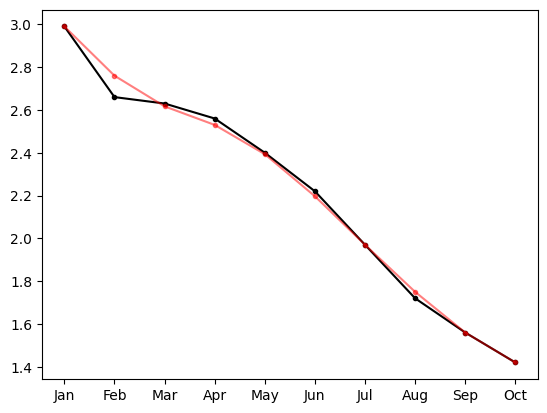

In [11]:
import pandas as pd
import matplotlib.pyplot as plt


monthvalues_df = pd.read_csv('data/series.csv')

monthvalues_df['smoothed'] = smooth_sma(monthvalues_df['value'], m=3)

plt.plot(monthvalues_df['month'], monthvalues_df['value'], 'k-', monthvalues_df['month'], monthvalues_df['value'], 'k.')
plt.plot(monthvalues_df['month'], monthvalues_df['smoothed'], 'r-', monthvalues_df['month'], monthvalues_df['smoothed'], 'r.', alpha=0.5)


## Метод 2: экспоненциальный (exponential)

Экспоненциальный подразумевает замену каждого элемента ряда $y_t$ на $l_t$ по следующей формуле:
$$
l_t = \alpha y_t + (1 - \alpha) l_{i-1}, \\
l_1 = y+1
$$
 где $\alpha$ - параметр сглаживания, $0 \leq \alpha \leq 1$.

In [12]:
def smooth_exponential(series, *, a = None):
    if not a:
        a = 2 / (len(series) + 1)
    smoothed_series = series.copy()

    for i in range(1, len(series)):
        smoothed_series[i] = a * series[i] + (1 - a) * smoothed_series[i - 1]
    
    return smoothed_series

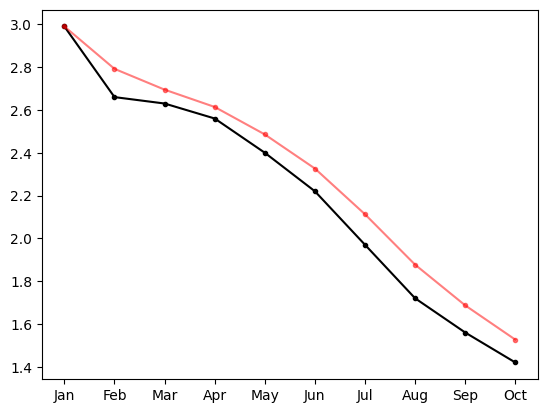

In [13]:
import pandas as pd
import matplotlib.pyplot as plt


monthvalues_df = pd.read_csv('data/series.csv')

monthvalues_df['smoothed'] = smooth_exponential(monthvalues_df['value'], a=0.6)

plt.plot(monthvalues_df['month'], monthvalues_df['value'], 'k-', monthvalues_df['month'], monthvalues_df['value'], 'k.')
plt.plot(monthvalues_df['month'], monthvalues_df['smoothed'], 'r-', monthvalues_df['month'], monthvalues_df['smoothed'], 'r.', alpha=0.5)


## Метод 3: взвешенная скользящая средняя (weighted moving average)

Метод взвешенной скользящей средней подразумевает замену каждого элемента ряда $y_t$ на $l_t$ по следующей формуле:
$$
l_t = \sum_{i = -k}^{k} p_i y_{t+i},
$$
где:
1. $(p_{-i}, p_{-i+1} ..., p_0, ..., p_{i-1}, p_i) = (\frac{1}{1 + ... + k + (k+1) + k + ... + 1}, \frac{2}{1 + ... + k + (k+1) + k + ... + 1}, ..., \frac{k + 1}{1 + ... + k + (k+1) + k + ... + 1}, ..., \frac{2}{1 + ... + k + (k+1) + k + ... + 1}, \frac{1}{1 + ... + k + (k+1) + k + ... + 1})$, если $m$ - нечетное число
2. где $(p_{-i}, p_{-i+1} ..., p_0, ..., p_{i-1}, p_i) = (\frac{1}{2(1 + ... + k + (k+1) + k + ... + 1)}, \frac{2}{1 + ... + k + (k+1) + k + ... + 1}, ..., \frac{k + 1}{1 + ... + k + (k+1) + k + ... + 1}, ..., \frac{2}{1 + ... + k + (k+1) + k + ... + 1}, \frac{1}{2(1 + ... + k + (k+1) + k + ... + 1)})$, если $m$ - четное число

In [14]:
def smooth_weighted_ma(series, weights):
    m = len(weights)
    smoothed_series = series.copy()
    k = (m - 1) // 2
    for t in range(k, len(series) - 1 - k):
        sum = 0
        for j in range(-k, k + 1):
            sum += weights[j + k] * series[t + j]
        smoothed_series[t] = sum

    return smoothed_series

In [15]:
def calculate_weights(series, m):
    k = m // 2

    if m % 2 == 1:
        weights = [None] * m
        summ = (k + 1) ** 2

        for i in range(0, k):
            weights[i] = (i + 1) / summ
        weights[k] = (k + 1) / summ
        for i in range(k + 1, m):
            weights[i] = (m - i) / summ

    else:
        weights = [None] * (m + 1)
        summ = (k + 1) ** 2 - 1

        for i in range(0, k):
            weights[i] = (i + 1) / summ
        weights[k] = (k + 1) / summ
        for i in range(k + 1, m + 1):
            weights[i] = (m + 1 - i) / summ
        
        weights[0] /= 2
        weights[-1] /= 2

    return weights

In [16]:
def smooth_WMA(series, m):
    smoothed_series = series.copy()
    k = m // 2
    weights = calculate_weights(series, m)

    print(sum(weights))
    
    for t in range(k, len(series) - 1 - k):
        val_weight_pairs = zip(series[t - k : t + k + 1], weights)
        smoothed = sum([y * w for y, w in val_weight_pairs])
        smoothed_series[t] = smoothed

    return smoothed_series


1.0


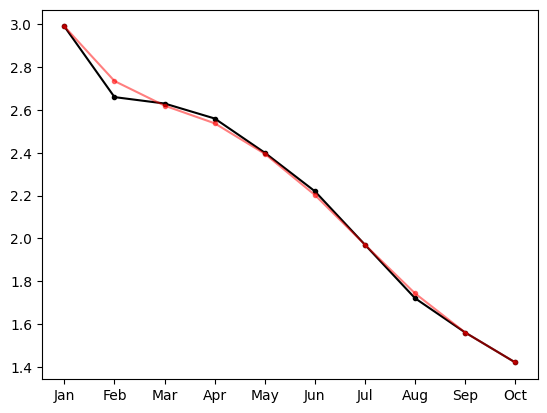

In [17]:
import pandas as pd
import matplotlib.pyplot as plt


monthvalues_df = pd.read_csv('data/series.csv')

monthvalues_df['smoothed'] = smooth_WMA(monthvalues_df['value'], 3)

plt.plot(monthvalues_df['month'], monthvalues_df['value'], 'k-', monthvalues_df['month'], monthvalues_df['value'], 'k.')
plt.plot(monthvalues_df['month'], monthvalues_df['smoothed'], 'r-', monthvalues_df['month'], monthvalues_df['smoothed'], 'r.', alpha=0.5)


# Прогнозирование с помощью простого экспоненциального сглаживания

Новый элемент временного ряда можно спрогнозировать с помощью формулы:

$$
\hat{y}_{T+1|T} = \alpha y_T + (1 - \alpha) \hat{y}_{T}
$$

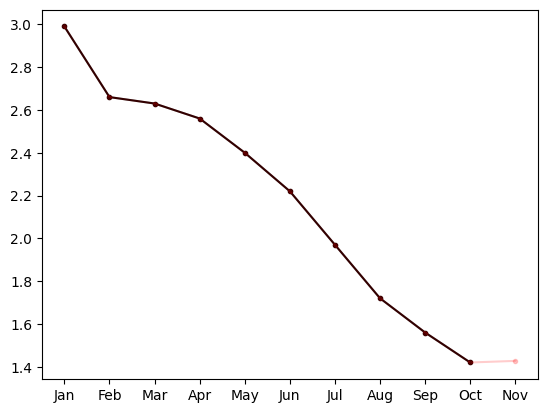

In [18]:
import pandas as pd
import matplotlib.pyplot as plt


def forecast_exponential(series, *, a = None):
    a = 2 / (len(series) + 1) if not a else a

    smoothed_series = smooth_exponential(series, a=a)
    next_val = a * series.iat[-1] + (1 - a) * smoothed_series.iat[-1]

    return next_val


monthvalues_df = pd.read_csv('data/series.csv')
forecasted_value = forecast_exponential(monthvalues_df['value'], a = .8)
new_monthvalues_df = pd.concat([monthvalues_df, pd.DataFrame({'month':['Nov'], 'value': [forecasted_value]})])

plt.plot(monthvalues_df['month'], monthvalues_df['value'], 'k-', monthvalues_df['month'], monthvalues_df['value'], 'k.')
plt.plot(new_monthvalues_df['month'], new_monthvalues_df['value'], 'r-', new_monthvalues_df['month'], new_monthvalues_df['value'], 'r.', alpha=0.2)
